In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# loading train data
train_df = pd.read_csv("/content/drive/MyDrive/#Research/#COVID_19_FAKE_NEWS/data/Constraint_Train.csv", sep=',')[['tweet','label']]
# loading test data
test_df = pd.read_csv("/content/drive/MyDrive/#Research/#COVID_19_FAKE_NEWS/data/Constraint_Val.csv", sep=',')[['tweet','label']]
# loading validation data
val_df = pd.read_csv("/content/drive/MyDrive/#Research/#COVID_19_FAKE_NEWS/data/english_test_with_labels.csv", sep=',')[['tweet','label']]

train_df.label[train_df.label=='real'] = 0
train_df.label[train_df.label=='fake'] = 1

test_df.label[test_df.label=='real'] = 0
test_df.label[test_df.label=='fake'] = 1


val_df.label[val_df.label=='real'] = 0
val_df.label[val_df.label=='fake'] = 1

In [ ]:
train_df

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,0
1,States reported 1121 deaths a small rise from ...,0
2,Politically Correct Woman (Almost) Uses Pandem...,1
3,#IndiaFightsCorona: We have 1524 #COVID testin...,0
4,Populous states can generate large case counts...,0
...,...,...
6415,A tiger tested positive for COVID-19 please st...,1
6416,???Autopsies prove that COVID-19 is??� a blood...,1
6417,_A post claims a COVID-19 vaccine has already ...,1
6418,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,1


In [ ]:
test_df

,tweet,label
0,Chinese converting to Islam after realising th...,1
1,11 out of 13 people (from the Diamond Princess...,1
2,"COVID-19 Is Caused By A Bacterium, Not Virus A...",1
3,Mike Pence in RNC speech praises Donald Trump’...,1
4,6/10 Sky's @EdConwaySky explains the latest #C...,0
...,...,...
2135,Donald Trump wrongly claimed that New Zealand ...,1
2136,Current understanding is #COVID19 spreads most...,0
2137,Nothing screams “I am sat around doing fuck al...,1
2138,Birx says COVID-19 outbreak not under control ...,1


In [ ]:
val_df

,tweet,label
0,Our daily update is published. States reported...,0
1,Alfalfa is the only cure for COVID-19.,1
2,President Trump Asked What He Would Do If He W...,1
3,States reported 630 deaths. We are still seein...,0
4,This is the sixth time a global health emergen...,0
...,...,...
2135,#CoronaVirusUpdates: State-wise details of Tot...,0
2136,Tonight 12(midnight) onwards Disaster Manageme...,1
2137,296 new cases of #COVID19Nigeria; Plateau-85 E...,0
2138,RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...,0


# Data Preprocessing

In [ ]:
import re
from tqdm import tqdm

def clean_text(sentence):
    sentence = re.sub("[\(\[].*?[\)\]]", "", sentence)
    sentence = re.sub(r"http\S+", " ", sentence)
    lower_sentence = sentence.lower()
    corrected_sentence = lower_sentence.encode('ascii', 'ignore').decode('ascii')
    corrected_sentence = re.sub('and/or', 'or', corrected_sentence)
    corrected_sentence = re.sub(r"i\'m", "i am ", corrected_sentence)
    corrected_sentence = re.sub(r"what's", "what is ", corrected_sentence)
    corrected_sentence = re.sub(r"\'s", " ", corrected_sentence)
    corrected_sentence = re.sub(r"\'ve", " have ", corrected_sentence)
    corrected_sentence = re.sub(r"can't", "can not ", corrected_sentence)
    corrected_sentence = re.sub(r"n't", " not ", corrected_sentence)
    corrected_sentence = re.sub(r"\'re", " are ", corrected_sentence)
    corrected_sentence = re.sub(r"\'d", " would ", corrected_sentence)
    corrected_sentence = re.sub(r"\'ll", " will ", corrected_sentence)
    corrected_sentence = re.sub(r"n't", " not ", corrected_sentence)
    corrected_sentence = re.sub('(?<=[a-zA-Z])/(?=[a-zA-Z])', ' or ', corrected_sentence)

    clean_sentence = re.sub(r'\.+', ".", corrected_sentence)
    clean_sentence = re.sub(r'\!+', "!", clean_sentence)
    clean_sentence = re.sub(r'\?+', "?", clean_sentence)
    clean_sentence = re.sub(r'\,+', ",", clean_sentence)
    clean_sentence = re.sub('[:@$//]', '', clean_sentence)
    clean_sentence = re.sub(r'\#*', "", clean_sentence)
    clean_sentence = re.sub(r'(?<=\d)[,\.]','',clean_sentence)
    clean_sentence = re.sub(r'\**', "", clean_sentence)
    clean_sentence = re.sub(r"\-", " ", clean_sentence)


    punctuation_spacer = str.maketrans({key: f"{key} " for key in "=.,?!"})
    clean_sentence = clean_sentence.translate(punctuation_spacer)
    clean_sentence = ' '.join(clean_sentence.split())
    return clean_sentence

In [ ]:
tqdm.pandas(desc="Cleaning train text")
train_df['cleaned_text'] = train_df['tweet'].progress_apply(clean_text)

tqdm.pandas(desc="Cleaning test text")
test_df['cleaned_text'] = test_df['tweet'].progress_apply(clean_text)

tqdm.pandas(desc="Cleaning validation text")
val_df['cleaned_text'] = val_df['tweet'].progress_apply(clean_text)

Cleaning validation text: 100%|██████████| 2140/2140 [00:00<00:00, 7317.77it/s]


In [ ]:
train_df

,tweet,label,cleaned_text
0,The CDC currently reports 99031 deaths. In gen...,0,the cdc currently reports 99031 deaths. in gen...
1,States reported 1121 deaths a small rise from ...,0,states reported 1121 deaths a small rise from ...
2,Politically Correct Woman (Almost) Uses Pandem...,1,politically correct woman uses pandemic as exc...
3,#IndiaFightsCorona: We have 1524 #COVID testin...,0,indiafightscorona we have 1524 covid testing l...
4,Populous states can generate large case counts...,0,populous states can generate large case counts...
...,...,...,...
6415,A tiger tested positive for COVID-19 please st...,1,a tiger tested positive for covid 19 please st...
6416,???Autopsies prove that COVID-19 is??� a blood...,1,? autopsies prove that covid 19 is? a blood cl...
6417,_A post claims a COVID-19 vaccine has already ...,1,_a post claims a covid 19 vaccine has already ...
6418,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,1,aamir khan donate 250 cr. in pm relief cares fund


In [ ]:
test_df

,tweet,label,cleaned_text
0,Chinese converting to Islam after realising th...,1,chinese converting to islam after realising th...
1,11 out of 13 people (from the Diamond Princess...,1,11 out of 13 people who had intially tested ne...
2,"COVID-19 Is Caused By A Bacterium, Not Virus A...",1,"covid 19 is caused by a bacterium, not virus a..."
3,Mike Pence in RNC speech praises Donald Trump’...,1,mike pence in rnc speech praises donald trumps...
4,6/10 Sky's @EdConwaySky explains the latest #C...,0,610 sky edconwaysky explains the latest covid1...
...,...,...,...
2135,Donald Trump wrongly claimed that New Zealand ...,1,donald trump wrongly claimed that new zealand ...
2136,Current understanding is #COVID19 spreads most...,0,current understanding is covid19 spreads mostl...
2137,Nothing screams “I am sat around doing fuck al...,1,nothing screams i am sat around doing fuck all...
2138,Birx says COVID-19 outbreak not under control ...,1,birx says covid 19 outbreak not under control ...


# Exploratory Data Analysis

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
def visualize_missing_value(train_df,test_df,val_df):
    print('Missing value of train data: \n',train_df.isnull().sum())
    print('Missing value of test data: \n',test_df.isnull().sum())
    print('Missing value of validation data: \n',test_df.isnull().sum())

    plt.figure(figsize=(20,7))
    plt.subplot(1,3,1)
    sns.heatmap(train_df.isnull(),yticklabels=False,cbar = False,cmap = 'viridis')
    plt.title('Train Data')
    plt.subplot(1,3,2)
    plt.title('Test Data')
    sns.heatmap(test_df.isnull(),yticklabels=False,cbar = False,cmap = 'viridis')
    plt.subplot(1,3,3)
    plt.title('Validation Data')
    sns.heatmap(val_df.isnull(),yticklabels=False,cbar = False,cmap = 'viridis')

Missing value of train data: 
 tweet           0
label           0
cleaned_text    0
dtype: int64
Missing value of test data: 
 tweet           0
label           0
cleaned_text    0
dtype: int64
Missing value of validation data: 
 tweet           0
label           0
cleaned_text    0
dtype: int64


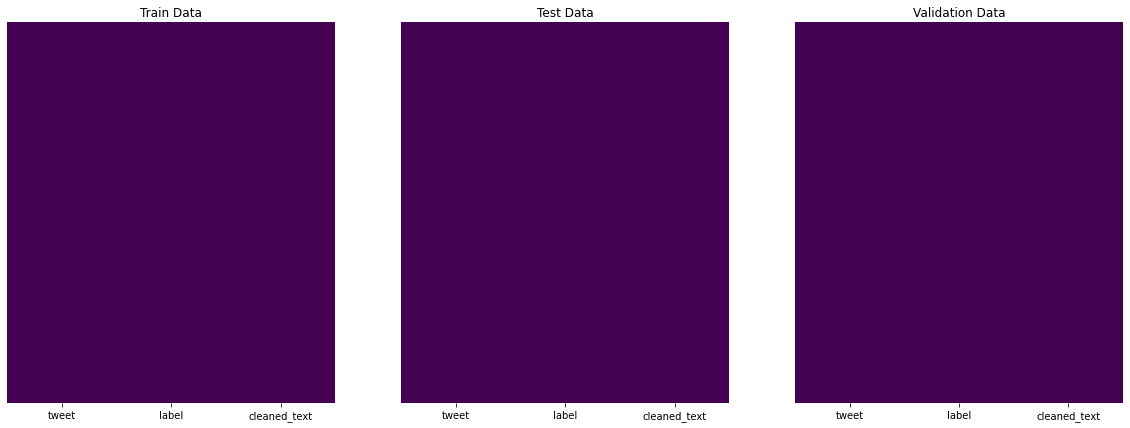

In [ ]:
# check if there were missing value in both the train and test set
visualize_missing_value(train_df,test_df,val_df)

## Observation
We do not lose any data after cleaning

## Visualizing distribution of number of words per post in Train data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Tokens Distribution in Train Data')

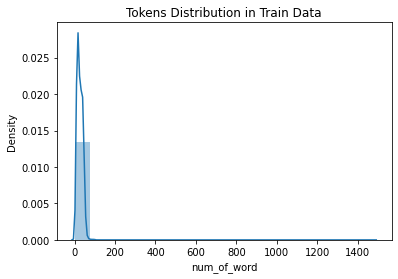

In [ ]:
train_df['num_of_word'] = train_df['cleaned_text'].apply(lambda x: len(x.split()))
sns.distplot(train_df['num_of_word'], bins = 20)
plt.title('Tokens Distribution in Train Data')

## Observation
As we can see there are very very small amount of post whose length is large. So we are going to quantile train_df['num_of_word'] to get the suitable sequence length.

In [ ]:
print('Quantile by 98%: ',int(train_df['num_of_word'].quantile(q = 0.98)))
print('Quantile by 99%: ',int(train_df['num_of_word'].quantile(q = 0.99)))

Quantile by 98%:  52
Quantile by 99%:  56


## Observation
As we can see if we take 52 as MAX_SEQUENCE_LENGTH, no info will be lost in 98% data and if we use 56 as MAX_SEQUENCE_LENGTH, no info will be lost in 99% data. As we are going to use bert which is much more computationally expensive, we are going to use 56 as MAX_SEQUENCE_LENGTH.

In [ ]:
MAX_SEQ_LENGTH = 56

## Visualizing distribution of labels

In [ ]:
def visualize_distribution_of_labels(train_data,test_data,val_data):
    print('Train Info : \n',train_data.value_counts())
    print('Test Info : \n',test_data.value_counts())
    print('Validation Info : \n',val_data.value_counts())

    print('In Percentage: ')
    print('Train Info : \n',train_data.value_counts()/len(train_data))
    print('Test Info : \n',test_data.value_counts()/len(test_data))
    print('Validation Info : \n',val_data.value_counts()/len(test_data))

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    sns.countplot(train_data)
    plt.title('Label Distribution in Train Data')
    plt.subplot(1,3,2)
    plt.title('Label Distribution in Test Data')
    sns.countplot(test_data)
    plt.subplot(1,3,3)
    plt.title('Label Distribution in Validation Data')
    sns.countplot(val_data)

Train Info : 
 0    3360
1    3060
Name: label, dtype: int64
Test Info : 
 0    1120
1    1020
Name: label, dtype: int64
Validation Info : 
 0    1120
1    1020
Name: label, dtype: int64
In Percentage: 
Train Info : 
 0    0.523364
1    0.476636
Name: label, dtype: float64
Test Info : 
 0    0.523364
1    0.476636
Name: label, dtype: float64
Validation Info : 
 0    0.523364
1    0.476636
Name: label, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


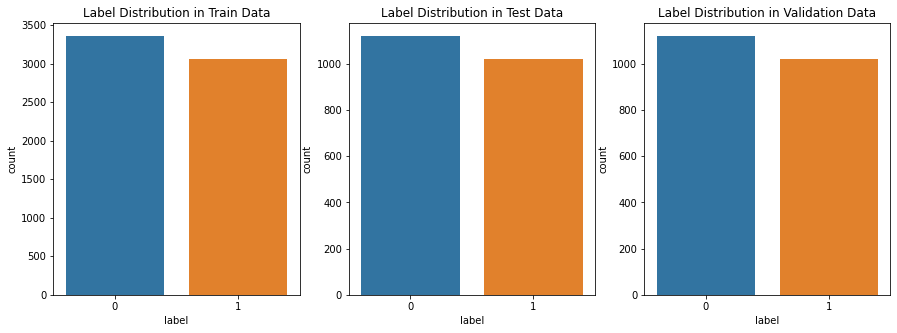

In [ ]:
visualize_distribution_of_labels(train_df['label'],test_df['label'],val_df['label'])

## Observation
As we can see data is nearly balanced accross all types of data 

# Bert Model (M1)


In [ ]:
!pip install transformers==2.10.0

In [ ]:
from transformers import TFBertModel
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
bert_model = TFBertModel.from_pretrained("bert-base-cased",output_hidden_states = True)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

## Preprocessing Text (Tokenization+Padding)

In [ ]:
import numpy as np

encoded_train_data = bert_tokenizer.batch_encode_plus(
    train_df['cleaned_text'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_SEQ_LENGTH,
)

encoded_test_data = bert_tokenizer.batch_encode_plus(
    test_df['cleaned_text'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_SEQ_LENGTH,
)

encoded_validation_data = bert_tokenizer.batch_encode_plus(
    val_df['cleaned_text'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_SEQ_LENGTH,
)

train_input_ids = np.array(encoded_train_data['input_ids']).reshape(-1,MAX_SEQ_LENGTH)
train_attention_mask = np.array(encoded_train_data['attention_mask']).reshape(-1,MAX_SEQ_LENGTH)

test_input_ids = np.array(encoded_test_data['input_ids']).reshape(-1,MAX_SEQ_LENGTH)
test_attention_mask = np.array(encoded_test_data['attention_mask']).reshape(-1,MAX_SEQ_LENGTH)

validation_input_ids = np.array(encoded_validation_data['input_ids']).reshape(-1,MAX_SEQ_LENGTH)
validation_attention_mask = np.array(encoded_validation_data['attention_mask']).reshape(-1,MAX_SEQ_LENGTH)


# Printing Info
print(f"Shape of 'train_input_ids' : {train_input_ids.shape} --> Shape of 'train_attention_mask' : {train_attention_mask.shape}")
print(f"Shape of 'test_input_ids' : {test_input_ids.shape} --> Shape of 'test_attention_mask' : {test_attention_mask.shape}")
print(f"Shape of 'validation_input_ids' : {validation_input_ids.shape} --> Shape of 'validation_attention_mask' : {validation_attention_mask.shape}")

Shape of 'train_input_ids' : (6420, 56) --> Shape of 'train_attention_mask' : (6420, 56)
Shape of 'test_input_ids' : (2140, 56) --> Shape of 'test_attention_mask' : (2140, 56)
Shape of 'validation_input_ids' : (2140, 56) --> Shape of 'validation_attention_mask' : (2140, 56)


## Creating Bert Model (M1)

In [ ]:
from tensorflow.keras.layers import LSTM,Dense,Input,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


token_inputs = Input((MAX_SEQ_LENGTH), dtype='int32', name='input_word_ids')
mask_inputs = Input((MAX_SEQ_LENGTH,), dtype='int32', name='input_masks')

bert_input = [token_inputs,mask_inputs]
bert_output = bert_model(bert_input)
lstm_output = LSTM(128)(bert_output[0])
dropout_output = Dropout(0.2)(lstm_output)
final_output = Dense(1,activation = 'sigmoid')(dropout_output)

my_bert_model = Model(bert_input,final_output)

adam = Adam(lr = 2e-5,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0,amsgrad=False)

my_bert_model.layers[2].trainable = False
my_bert_model.compile(loss='binary_crossentropy', optimizer = adam, metrics = ['acc'])
my_bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 56)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 56)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    ((None, 56, 768),    108310272   ['input_word_ids[0][0]',         
                                 (None, 768),                     'input_masks[0][0]']            
                                 ((None, 56, 768),                                                
                                 (None, 56, 768),                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#training
my_bert_model.fit( [train_input_ids, train_attention_mask], train_df['label'].values.astype('float32'), 
          validation_data=( [validation_input_ids, validation_attention_mask] ,val_df['label'].values.astype('float32')),
          batch_size=32 ,epochs= 3)

Epoch 1/3
201/201 [==============================] - 100s 398ms/step - loss: 0.6096 - acc: 0.6942 - val_loss: 0.7816 - val_acc: 0.4832
Epoch 2/3
201/201 [==============================] - 75s 375ms/step - loss: 0.4155 - acc: 0.8400 - val_loss: 1.1242 - val_acc: 0.4762
Epoch 3/3
201/201 [==============================] - 75s 374ms/step - loss: 0.3077 - acc: 0.8766 - val_loss: 1.2963 - val_acc: 0.4804


67/67 [==============================] - 18s 271ms/step - loss: 0.3027 - acc: 0.8822
Accuracy : 0.8822429776191711
67/67 [==============================] - 17s 259ms/step
[[990 130]
 [122 898]]
              precision    recall  f1-score   support

         0.0       0.89      0.88      0.89      1120
         1.0       0.87      0.88      0.88      1020

    accuracy                           0.88      2140
   macro avg       0.88      0.88      0.88      2140
weighted avg       0.88      0.88      0.88      2140



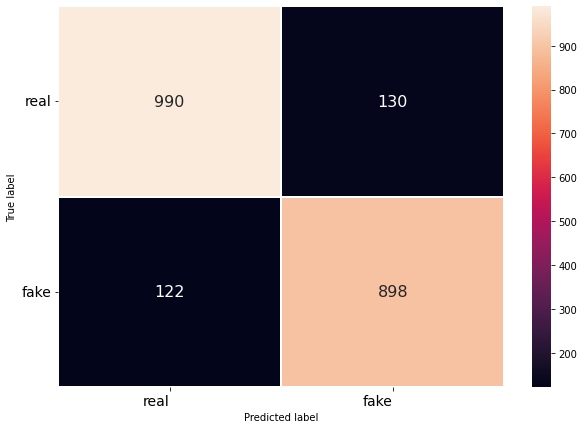

In [ ]:
loss, acc = my_bert_model.evaluate( [ test_input_ids, test_attention_mask ],test_df['label'].values.astype('float32'), verbose = 1)
print(f'Accuracy : {acc}')


prediction = my_bert_model.predict( [ test_input_ids, test_attention_mask ], verbose= 1 )
prediction = np.round(prediction)

from sklearn.metrics import confusion_matrix,classification_report

# Detailed classification report
cm = confusion_matrix(test_df.label.values.astype('float'),prediction)
print(cm)
print(classification_report(test_df.label.values.astype('float'),prediction))
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
  
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", linewidths=1 , annot_kws={'size':16, "ha": 'center',"va": 'center'})
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print_confusion_matrix(cm, class_names=['real', 'fake'])

In [ ]:
my_bert_model.save("/content/drive/MyDrive/#Research/#COVID_19_FAKE_NEWS/saved models/m1")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/#Research/#COVID_19_FAKE_NEWS/saved models/m1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/#Research/#COVID_19_FAKE_NEWS/saved models/m1/assets


# Bert without LSTM (M2)

In [ ]:
from tensorflow.keras.layers import LSTM,Dense,Input,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


token_inputs = Input((MAX_SEQ_LENGTH), dtype='int32', name='input_word_ids')
mask_inputs = Input((MAX_SEQ_LENGTH,), dtype='int32', name='input_masks')

bert_input = [token_inputs,mask_inputs]
bert_output = bert_model(bert_input)
d1_output = Dense(128,activation='relu')(bert_output[1])
dropout_output1 = Dropout(0.3)(d1_output)
d2_output = Dense(64,activation='relu')(dropout_output1)
dropout_output2 = Dropout(0.2)(d2_output)
final_output = Dense(1,activation = 'sigmoid')(dropout_output2)

my_bert_model = Model(bert_input,final_output)

adam = Adam(lr = 2e-5,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0,amsgrad=False)

my_bert_model.layers[2].trainable = False
my_bert_model.compile(loss='binary_crossentropy', optimizer = adam, metrics = ['acc'])
my_bert_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 56)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 56)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    ((None, 56, 768),    108310272   ['input_word_ids[0][0]',         
                                 (None, 768),                     'input_masks[0][0]']            
                                 ((None, 56, 768),                                                
                                 (None, 56, 768),                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#training
my_bert_model.fit( [train_input_ids, train_attention_mask], train_df['label'].values.astype('float32'), 
          validation_data=( [validation_input_ids, validation_attention_mask] ,val_df['label'].values.astype('float32')),
          batch_size=32 ,epochs= 3)

Epoch 1/3
201/201 [==============================] - 96s 391ms/step - loss: 0.7213 - acc: 0.4980 - val_loss: 0.6969 - val_acc: 0.5234
Epoch 2/3
201/201 [==============================] - 73s 363ms/step - loss: 0.6892 - acc: 0.5464 - val_loss: 0.6944 - val_acc: 0.5117
Epoch 3/3
201/201 [==============================] - 73s 361ms/step - loss: 0.6796 - acc: 0.5623 - val_loss: 0.6960 - val_acc: 0.4850


67/67 [==============================] - 18s 264ms/step - loss: 0.6540 - acc: 0.7589
Accuracy : 0.7588785290718079
67/67 [==============================] - 21s 256ms/step
[[904 216]
 [300 720]]
              precision    recall  f1-score   support

         0.0       0.75      0.81      0.78      1120
         1.0       0.77      0.71      0.74      1020

    accuracy                           0.76      2140
   macro avg       0.76      0.76      0.76      2140
weighted avg       0.76      0.76      0.76      2140



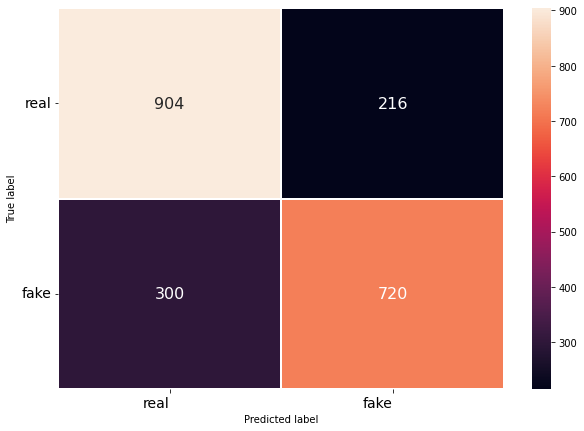

In [ ]:
loss, acc = my_bert_model.evaluate( [ test_input_ids, test_attention_mask ],test_df['label'].values.astype('float32'), verbose = 1)
print(f'Accuracy : {acc}')


prediction = my_bert_model.predict( [ test_input_ids, test_attention_mask ], verbose= 1 )
prediction = np.round(prediction)

from sklearn.metrics import confusion_matrix,classification_report

# Detailed classification report
cm = confusion_matrix(test_df.label.values.astype('float'),prediction)
print(cm)
print(classification_report(test_df.label.values.astype('float'),prediction))
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
  
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", linewidths=1 , annot_kws={'size':16, "ha": 'center',"va": 'center'})
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print_confusion_matrix(cm, class_names=['real', 'fake'])

In [ ]:
my_bert_model.save("/content/drive/MyDrive/#Research/#COVID_19_FAKE_NEWS/saved models/m2")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/#Research/#COVID_19_FAKE_NEWS/saved models/m2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/#Research/#COVID_19_FAKE_NEWS/saved models/m2/assets


# Albert Model (M3)

In [ ]:
from transformers import TFAlbertModel, AlbertTokenizer

albert_model = TFAlbertModel.from_pretrained("albert-base-v1")
albert_tokenizer = AlbertTokenizer.from_pretrained("albert-base-v1",output_hidden_states = True)

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/63.0M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

## Preprocessing Text (Tokenization+Padding)

In [ ]:
import numpy as np

encoded_train_data = albert_tokenizer.batch_encode_plus(
    train_df['cleaned_text'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_SEQ_LENGTH,
)

encoded_test_data = albert_tokenizer.batch_encode_plus(
    test_df['cleaned_text'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_SEQ_LENGTH,
)

encoded_validation_data = albert_tokenizer.batch_encode_plus(
    val_df['cleaned_text'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_SEQ_LENGTH,
)

train_input_ids = np.array(encoded_train_data['input_ids']).reshape(-1,MAX_SEQ_LENGTH)
train_attention_mask = np.array(encoded_train_data['attention_mask']).reshape(-1,MAX_SEQ_LENGTH)

test_input_ids = np.array(encoded_test_data['input_ids']).reshape(-1,MAX_SEQ_LENGTH)
test_attention_mask = np.array(encoded_test_data['attention_mask']).reshape(-1,MAX_SEQ_LENGTH)

validation_input_ids = np.array(encoded_validation_data['input_ids']).reshape(-1,MAX_SEQ_LENGTH)
validation_attention_mask = np.array(encoded_validation_data['attention_mask']).reshape(-1,MAX_SEQ_LENGTH)


# Printing Info
print(f"Shape of 'train_input_ids' : {train_input_ids.shape} --> Shape of 'train_attention_mask' : {train_attention_mask.shape}")
print(f"Shape of 'test_input_ids' : {test_input_ids.shape} --> Shape of 'test_attention_mask' : {test_attention_mask.shape}")
print(f"Shape of 'validation_input_ids' : {validation_input_ids.shape} --> Shape of 'validation_attention_mask' : {validation_attention_mask.shape}")

Shape of 'train_input_ids' : (6420, 56) --> Shape of 'train_attention_mask' : (6420, 56)
Shape of 'test_input_ids' : (2140, 56) --> Shape of 'test_attention_mask' : (2140, 56)
Shape of 'validation_input_ids' : (2140, 56) --> Shape of 'validation_attention_mask' : (2140, 56)


## Creating Albert Model

In [ ]:
token_inputs = Input((MAX_SEQ_LENGTH), dtype='int32', name='input_word_ids')
mask_inputs = Input((MAX_SEQ_LENGTH,), dtype='int32', name='input_masks')

albert_input = [token_inputs,mask_inputs]
albert_output = albert_model(albert_input)
lstm_output = LSTM(128)(albert_output[0])
dropout_output = Dropout(0.2)(lstm_output)
final_output = Dense(1,activation = 'sigmoid')(dropout_output)

my_albert_model = Model(albert_input,final_output)

adam = Adam(lr = 2e-5,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0,amsgrad=False)
my_albert_model.compile(loss='binary_crossentropy', optimizer = adam, metrics = ['acc'])

my_albert_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 56)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 56)]         0           []                               
                                                                                                  
 tf_albert_model (TFAlbertModel  ((None, 56, 768),   11683584    ['input_word_ids[0][0]',         
 )                               (None, 768))                     'input_masks[0][0]']            
                                                                                                  
 lstm_2 (LSTM)                  (None, 128)          459264      ['tf_albert_model[1][0]']  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
my_albert_model.fit( [train_input_ids, train_attention_mask], train_df['label'].values.astype('float'), 
          validation_data=( [ validation_input_ids, validation_attention_mask] ,val_df['label'].values.astype('float')),
          batch_size=32 ,epochs= 3)

Epoch 1/3


201/201 [==============================] - 195s 828ms/step - loss: 0.3229 - acc: 0.8609 - val_loss: 1.5140 - val_acc: 0.4771
Epoch 2/3
201/201 [==============================] - 160s 799ms/step - loss: 0.1764 - acc: 0.9335 - val_loss: 2.0473 - val_acc: 0.4818
Epoch 3/3
201/201 [==============================] - 160s 798ms/step - loss: 0.1155 - acc: 0.9589 - val_loss: 2.3100 - val_acc: 0.4808


67/67 [==============================] - 18s 265ms/step - loss: 0.2030 - acc: 0.9285
Accuracy : 0.9285046458244324
67/67 [==============================] - 21s 259ms/step
[[1095   25]
 [ 128  892]]
              precision    recall  f1-score   support

         0.0       0.90      0.98      0.93      1120
         1.0       0.97      0.87      0.92      1020

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140



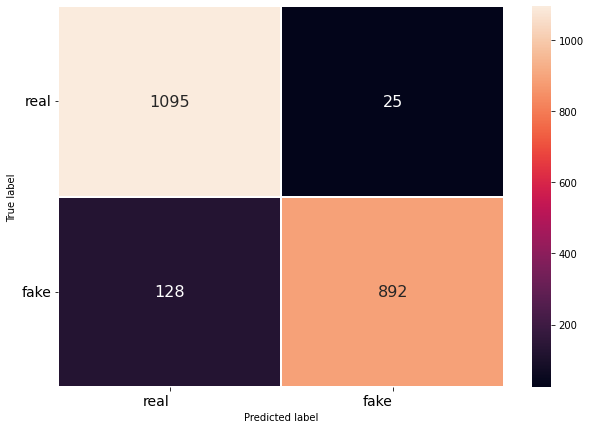

In [ ]:
loss, acc = my_albert_model.evaluate( [ test_input_ids, test_attention_mask ],test_df['label'].values.astype('float32'), verbose = 1)
print(f'Accuracy : {acc}')


prediction = my_albert_model.predict( [ test_input_ids, test_attention_mask ], verbose= 1 )
prediction = np.round(prediction)

from sklearn.metrics import confusion_matrix,classification_report

# Detailed classification report
cm = confusion_matrix(test_df.label.values.astype('float'),prediction)
print(cm)
print(classification_report(test_df.label.values.astype('float'),prediction))
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
  
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", linewidths=1 , annot_kws={'size':16, "ha": 'center',"va": 'center'})
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print_confusion_matrix(cm, class_names=['real', 'fake'])

In [ ]:
my_albert_model.save("/content/drive/MyDrive/#Research/#COVID_19_FAKE_NEWS/saved models/m3")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/#Research/#COVID_19_FAKE_NEWS/saved models/m3/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/#Research/#COVID_19_FAKE_NEWS/saved models/m3/assets


# Roberta Model (M4)

In [ ]:
from transformers import TFRobertaModel,RobertaTokenizer

roberta_model = TFRobertaModel.from_pretrained("roberta-base",output_hidden_states = True)
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

## Preprocessing Text (Tokenization+Padding)



In [ ]:
import numpy as np

encoded_train_data = roberta_tokenizer.batch_encode_plus(
    train_df['tweet'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_SEQ_LENGTH,
)

encoded_test_data = roberta_tokenizer.batch_encode_plus(
    test_df['tweet'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_SEQ_LENGTH,
)

encoded_validation_data = roberta_tokenizer.batch_encode_plus(
    val_df['tweet'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_SEQ_LENGTH,
)

train_input_ids = np.array(encoded_train_data['input_ids']).reshape(-1,MAX_SEQ_LENGTH)
train_attention_mask = np.array(encoded_train_data['attention_mask']).reshape(-1,MAX_SEQ_LENGTH)

test_input_ids = np.array(encoded_test_data['input_ids']).reshape(-1,MAX_SEQ_LENGTH)
test_attention_mask = np.array(encoded_test_data['attention_mask']).reshape(-1,MAX_SEQ_LENGTH)

validation_input_ids = np.array(encoded_validation_data['input_ids']).reshape(-1,MAX_SEQ_LENGTH)
validation_attention_mask = np.array(encoded_validation_data['attention_mask']).reshape(-1,MAX_SEQ_LENGTH)


# Printing Info
print(f"Shape of 'train_input_ids' : {train_input_ids.shape} --> Shape of 'train_attention_mask' : {train_attention_mask.shape}")
print(f"Shape of 'test_input_ids' : {test_input_ids.shape} --> Shape of 'test_attention_mask' : {test_attention_mask.shape}")
print(f"Shape of 'validation_input_ids' : {validation_input_ids.shape} --> Shape of 'validation_attention_mask' : {validation_attention_mask.shape}")

Shape of 'train_input_ids' : (6420, 56) --> Shape of 'train_attention_mask' : (6420, 56)
Shape of 'test_input_ids' : (2140, 56) --> Shape of 'test_attention_mask' : (2140, 56)
Shape of 'validation_input_ids' : (2140, 56) --> Shape of 'validation_attention_mask' : (2140, 56)


## Creating Roberta Model

In [ ]:
token_inputs = Input((MAX_SEQ_LENGTH), dtype='int32', name='input_word_ids')
mask_inputs = Input((MAX_SEQ_LENGTH,), dtype='int32', name='input_masks')

roberta_input = [token_inputs,mask_inputs]
roberta_output = roberta_model(roberta_input)
lstm_output = LSTM(128)(roberta_output[0])
dropout_output = Dropout(0.2)(lstm_output)
final_output = Dense(1,activation = 'sigmoid')(dropout_output)

my_roberta_model = Model(roberta_input,final_output)

adam = Adam(lr = 2e-5,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0,amsgrad=False)
my_roberta_model.compile(loss='binary_crossentropy', optimizer = adam, metrics = ['acc'])

my_roberta_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 56)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 56)]         0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  ((None, 56, 768),   124645632   ['input_word_ids[0][0]',         
 odel)                           (None, 768),                     'input_masks[0][0]']            
                                 ((None, 56, 768),                                                
                                 (None, 56, 768),                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
my_roberta_model.fit( [train_input_ids, train_attention_mask], train_df['label'].values.astype('float'), 
          validation_data=( [ validation_input_ids, validation_attention_mask] ,val_df['label'].values.astype('float')),
          batch_size=32 ,epochs= 5)

Epoch 1/5


201/201 [==============================] - 208s 899ms/step - loss: 0.2151 - acc: 0.9093 - val_loss: 0.1361 - val_acc: 0.9477
Epoch 2/5
201/201 [==============================] - 172s 856ms/step - loss: 0.0721 - acc: 0.9734 - val_loss: 0.0844 - val_acc: 0.9734
Epoch 3/5
201/201 [==============================] - 173s 861ms/step - loss: 0.0372 - acc: 0.9877 - val_loss: 0.0750 - val_acc: 0.9752
Epoch 4/5
201/201 [==============================] - 170s 846ms/step - loss: 0.0210 - acc: 0.9942 - val_loss: 0.1143 - val_acc: 0.9654
Epoch 5/5
201/201 [==============================] - 170s 845ms/step - loss: 0.0192 - acc: 0.9941 - val_loss: 0.0805 - val_acc: 0.9766


67/67 [==============================] - 18s 264ms/step - loss: 0.0748 - acc: 0.9766
Accuracy : 0.9766355156898499
67/67 [==============================] - 21s 258ms/step
[[1106   14]
 [  36  984]]
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1120
         1.0       0.99      0.96      0.98      1020

    accuracy                           0.98      2140
   macro avg       0.98      0.98      0.98      2140
weighted avg       0.98      0.98      0.98      2140



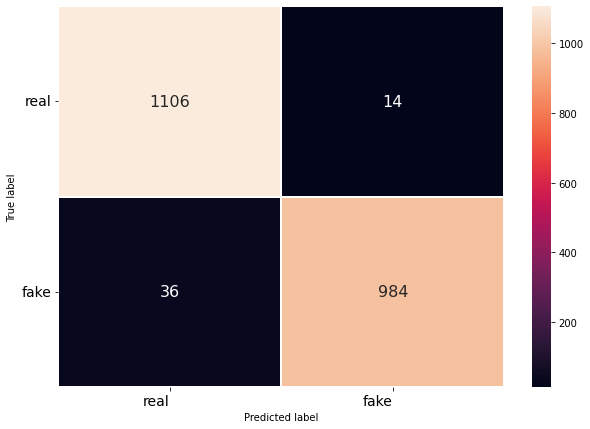

In [ ]:
loss, acc = my_roberta_model.evaluate( [ test_input_ids, test_attention_mask ],test_df['label'].values.astype('float32'), verbose = 1)
print(f'Accuracy : {acc}')


prediction = my_roberta_model.predict( [ test_input_ids, test_attention_mask ], verbose= 1 )
prediction = np.round(prediction)

from sklearn.metrics import confusion_matrix,classification_report

# Detailed classification report
cm = confusion_matrix(test_df.label.values.astype('float'),prediction)
print(cm)
print(classification_report(test_df.label.values.astype('float'),prediction))
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
  
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", linewidths=1 , annot_kws={'size':16, "ha": 'center',"va": 'center'})
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print_confusion_matrix(cm, class_names=['real', 'fake'])

In [ ]:
my_roberta_model.save("/content/drive/MyDrive/#Research/#COVID_19_FAKE_NEWS/saved models/m4")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/#Research/#COVID_19_FAKE_NEWS/saved models/m4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/#Research/#COVID_19_FAKE_NEWS/saved models/m4/assets


# Hybrid Model 1: Bert + Albert (M5)

## Preprocessing Text (Tokenization+Padding)

In [ ]:
encoded_train_data = bert_tokenizer.batch_encode_plus(
    train_df['cleaned_text'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_SEQ_LENGTH,
)

encoded_test_data = bert_tokenizer.batch_encode_plus(
    test_df['cleaned_text'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_SEQ_LENGTH,
)

encoded_validation_data = bert_tokenizer.batch_encode_plus(
    val_df['cleaned_text'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_SEQ_LENGTH,
)

train_input_ids1 = np.array(encoded_train_data['input_ids']).reshape(-1,MAX_SEQ_LENGTH)
train_attention_mask1 = np.array(encoded_train_data['attention_mask']).reshape(-1,MAX_SEQ_LENGTH)

test_input_ids1 = np.array(encoded_test_data['input_ids']).reshape(-1,MAX_SEQ_LENGTH)
test_attention_mask1 = np.array(encoded_test_data['attention_mask']).reshape(-1,MAX_SEQ_LENGTH)

validation_input_ids1 = np.array(encoded_validation_data['input_ids']).reshape(-1,MAX_SEQ_LENGTH)
validation_attention_mask1 = np.array(encoded_validation_data['attention_mask']).reshape(-1,MAX_SEQ_LENGTH)


encoded_train_data = albert_tokenizer.batch_encode_plus(
    train_df['cleaned_text'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_SEQ_LENGTH,
)

encoded_test_data = albert_tokenizer.batch_encode_plus(
    test_df['cleaned_text'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_SEQ_LENGTH,
)

encoded_validation_data = albert_tokenizer.batch_encode_plus(
    val_df['cleaned_text'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_SEQ_LENGTH,
)

train_input_ids2 = np.array(encoded_train_data['input_ids']).reshape(-1,MAX_SEQ_LENGTH)
train_attention_mask2 = np.array(encoded_train_data['attention_mask']).reshape(-1,MAX_SEQ_LENGTH)

test_input_ids2 = np.array(encoded_test_data['input_ids']).reshape(-1,MAX_SEQ_LENGTH)
test_attention_mask2 = np.array(encoded_test_data['attention_mask']).reshape(-1,MAX_SEQ_LENGTH)

validation_input_ids2 = np.array(encoded_validation_data['input_ids']).reshape(-1,MAX_SEQ_LENGTH)
validation_attention_mask2 = np.array(encoded_validation_data['attention_mask']).reshape(-1,MAX_SEQ_LENGTH)



## Creating Hybrid Model

In [ ]:
token_inputs1 = Input((MAX_SEQ_LENGTH), dtype='int32', name='input_word_ids1')
mask_inputs1 = Input((MAX_SEQ_LENGTH,), dtype='int32', name='input_masks1')

token_inputs2 = Input((MAX_SEQ_LENGTH), dtype='int32', name='input_word_ids2')
mask_inputs2 = Input((MAX_SEQ_LENGTH,), dtype='int32', name='input_masks2')

bert_input = [token_inputs1,mask_inputs1]
bert_output = bert_model(bert_input)

albert_input = [token_inputs2,mask_inputs2]
albert_output = albert_model(albert_input)

cc1 = tf.keras.layers.Concatenate()([bert_output[1], albert_output[1]])

d1_output = Dense(128,activation='relu')(cc1)
dropout_output1 = Dropout(0.3)(d1_output)
d2_output = Dense(64,activation='relu')(dropout_output1)
dropout_output2 = Dropout(0.2)(d2_output)
final_output = Dense(1,activation = 'sigmoid')(dropout_output2)

my_hybrid_model_1 = Model(inputs = [bert_input,albert_input], outputs = final_output)

adam = Adam(lr = 2e-5,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0,amsgrad=False)

# my_bert_model.layers[2].trainable = False
my_hybrid_model_1.compile(loss='binary_crossentropy', optimizer = adam, metrics = ['acc'])
my_hybrid_model_1.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids1 (InputLayer)   [(None, 56)]         0           []                               
                                                                                                  
 input_masks1 (InputLayer)      [(None, 56)]         0           []                               
                                                                                                  
 input_word_ids2 (InputLayer)   [(None, 56)]         0           []                               
                                                                                                  
 input_masks2 (InputLayer)      [(None, 56)]         0           []                               
                                                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
my_hybrid_model_1.fit( [[train_input_ids1, train_attention_mask1], [train_input_ids2, train_attention_mask2]], train_df['label'].values.astype('float'), 
          validation_data=( [[ validation_input_ids1, validation_attention_mask1], [validation_input_ids2, validation_attention_mask2]] ,val_df['label'].values.astype('float')),
          batch_size=32 ,epochs= 5)

Epoch 1/5
201/201 [==============================] - 296s 1s/step - loss: 0.1677 - acc: 0.9455 - val_loss: 2.3433 - val_acc: 0.4762
Epoch 2/5
201/201 [==============================] - 226s 1s/step - loss: 0.0744 - acc: 0.9771 - val_loss: 2.9202 - val_acc: 0.4743
Epoch 3/5
201/201 [==============================] - 225s 1s/step - loss: 0.0577 - acc: 0.9819 - val_loss: 3.0356 - val_acc: 0.4785
Epoch 4/5
201/201 [==============================] - 225s 1s/step - loss: 0.0337 - acc: 0.9891 - val_loss: 3.9451 - val_acc: 0.4771
Epoch 5/5
201/201 [==============================] - 227s 1s/step - loss: 0.0318 - acc: 0.9916 - val_loss: 3.9236 - val_acc: 0.4771


67/67 [==============================] - 35s 518ms/step - loss: 0.1978 - acc: 0.9509
Accuracy : 0.9509345889091492
67/67 [==============================] - 38s 501ms/step
[[1056   64]
 [  41  979]]
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      1120
         1.0       0.94      0.96      0.95      1020

    accuracy                           0.95      2140
   macro avg       0.95      0.95      0.95      2140
weighted avg       0.95      0.95      0.95      2140



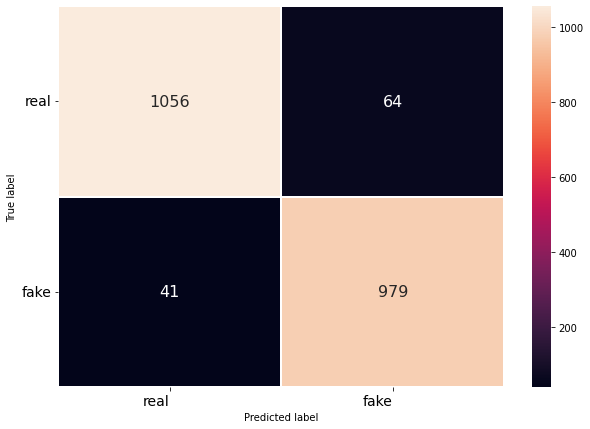

In [ ]:
loss, acc = my_hybrid_model_1.evaluate( [[ test_input_ids1, test_attention_mask1 ], [test_input_ids2, test_attention_mask2]],test_df['label'].values.astype('float32'), verbose = 1)
print(f'Accuracy : {acc}')


prediction = my_hybrid_model_1.predict( [[ test_input_ids1, test_attention_mask1 ], [test_input_ids2, test_attention_mask2]], verbose= 1 )
prediction = np.round(prediction)

from sklearn.metrics import confusion_matrix,classification_report

# Detailed classification report
cm = confusion_matrix(test_df.label.values.astype('float'),prediction)
print(cm)
print(classification_report(test_df.label.values.astype('float'),prediction))
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
  
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", linewidths=1 , annot_kws={'size':16, "ha": 'center',"va": 'center'})
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print_confusion_matrix(cm, class_names=['real', 'fake'])

In [ ]:
my_hybrid_model_1.save("/content/drive/MyDrive/#Research/#COVID_19_FAKE_NEWS/saved models/m5")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/#Research/#COVID_19_FAKE_NEWS/saved models/m5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/#Research/#COVID_19_FAKE_NEWS/saved models/m5/assets
